# 5 순환 신경망(RNN)

지금까지 살펴본 feed forward형태의 신경망과는 달리 순환적 특징을 가진 순환 신경망(Recurrent neural network)를 다뤄보자.

RNN은 특히 시계열 데이터를 잘 다룬다.

## 5.1 확률과 언어 모델

### 5.1.1 word2vec을 확률 관점에서 바라보다

t번째 단어를 target, 그 전후 단어(t-1번째, t+1번째)를 context로 생각해보자.

위의 상황에서 CBOW모델의 확률은 $P(w_t | w_{t-1}, w_{t+1})$이다. (window_size = 1)

이번엔 비대칭 window_size를 갖는, 왼쪽 window = 2, 오른쪽 window = 0인 상황을 생각해보자.

수식으로 표현하면 다음과 같다. 

$$P(w_t | w_{t-2}, w_{t-1})$$

cross entrophy loss에 의해 손실함수를 유도하면 다음과 같다.

$$ L = -\log P(w_t | w_{t-2}, w_{t-1}) $$

CBOW 모델의 학습으로 수행하는 일은 말뭉치 전체의 손실 함수의 총합을 최소화하는 가중치 매개변수를 찾는 것이다.

이처럼 CBOW 모델을 학습시키는 본래 목적은 맥락으로부터 타깃을 정확하게 추측하는 것이다.

그럼 CBOW 모델의 본래 목적인 '맥락으로부터 타깃을 추측하는 것'은 어디에 사용할 수 있을까?

이때 '언어 모델'이 등장한다.

### 5.1.2 언어 모델

P195에 있는 마지막 수식 잘못 된거 아닌가? $\prod_{t=1}^m P(w_t | w_1, \cdots, w_{t-1})$ 아닌가?

__언어 모델(Language Model)__은 단어 나열에 확률을 부여한다. 특정한 단어의 시퀸스에 대해서, 그 시퀸스가 일어날 가능성이 어느 정도인지를 확률로 평가하는 것이다.

언어 모델을 수식으로 표현해보자.

$w_1, \cdots, w_m$이라는 m개 단어로 된 문장을 생각해보자. 이때 단어가 $w_1, \cdots, w_m$이라는 순서로 출현할 확률을 $P(w_1, \cdots, w_m)$이라고 하자.

이 동시 확률 $P(w_1, \cdots, w_m)$ 은 사후 확률을 사용하여 다음과 같이 분해할 수 있다.

$$\begin{align*}P(w_1, \cdots, w_m) &= P(w_m | w_{1}, \cdots, w_{m-1})P(w_{m-1} | w_{1}, \cdots, w_{m-2})\cdots P(w_3 | w_1, w_2)P(w_2 | w_1)P(w_1) \\ &= \prod_{t=1}^m P(w_t | w_1, \cdots, w_{t-1})\end{align*}$$

정리하자면, 우리의 목표는 $P(w_t | w_1, \cdots, w_{t-1})$ 이라는 확률을 얻는 것이다.

이 확률을 계산할 수 있다면 언어 모델의 동시 확률 $P(w_1, \cdots, w_m)$을 구할 수 있다.

<img src="deep_learning_2_images/fig 5-3.png" width="70%" height="50%">


### 5.1.3 CBOW 모델을 언어 모델로?

word2vec의 CBOW 모델을 언어 모델에 적용하려면 어떻게 하면 좋을까?

맥락의 크기를 특정 값으로 한정하여 근사적으로 나타낼 수 있다.

$$\begin{align*}P(w_1, \cdots, w_m) &= \prod_{t=1}^m P(w_t | w_1, \cdots, w_{t-1}) \\ &\approx \prod_{t=1}^m P(w_t | w_{t-2}, w_{t-1}\end{align*}$$ 

위에서는 맥락을 왼쪽 2개의 단어로 한정한다. 상황에 따라 맥락의 크기는 달라 질 수 있다.

우리가 이전에 보았던 CBOW 모델은 은닉층에서 단어벡터들이 더해지므로 맥락의 단어 순서는 무시된다. 예를 들어 (you, say)와 (say, you)가 같다.

이상적으로 맥락을 고려한 단어 순서도 고려한 모델이 바람직하다. 이를 위해 다음 그림의 오른쪽과 같이 맥락의 단어 벡터를 은닉층에서 연결하는 방식을 생각할 수 있다.

<img src="deep_learning_2_images/fig 5-5.png" width="70%" height="50%">

그러나 연결하는 방식을 취하면 맥락의 크기에 비례해 자우치 매개변수도 늘어나는 단점이 있다.

이 단점을 해결한 것이 RNN이다.

## 5.2 RNN이란?

Recurrent Neural Network의 약자로 순환하는 신경망을 뜻한다.

### 5.2.1 순환하는 신경망

신경망에 순환하는 경로가 존재하여 이 경로를 따라 데이터가 순환되어 과거의 정보를 기억하는 동시에 최신 데이터로 갱신될 수 있다.

<img src="deep_learning_2_images/fig 5-6.png" width="30%" height="30%">

이는 시계열 데이터 $(\textbf{x}_0, \textbf{x}_1, \cdots, \textbf{x}_t, \cdots)$가 RNN 계층에 입력되고 $(\textbf{h}_0, \textbf{h}_1, \cdots, \textbf{h}_t, \cdots)$가 출력됨을 표현한 것이다.

각 시각에 입력되는 $(\textbf{x}_t)$는 벡터라고 가정하자. 문장을 다루는 경우 각 단어의 분산 표현이 $\textbf{x}_t$가 된다.

이 분산 표현이 순서대로 하나씩 RNN 계층에 입력되는 것이다.

### 5.2.2 순환 구조 펼치기

다음은 RNN 계층의 순환 구조를 펼친 것인데 이때까지 본 신경망들과 다르게 다수의 RNN 계층 모두가 실제로는 '같은 계층'인 것이 특징이다.

<img src="deep_learning_2_images/fig 5-8.png" width="70%" height="30%">

각 시각의 RNN 계층은 그 계층으로의 입력과 1개 전의 RNN 계층으로부터의 출력을 받는다. 

그리고 이 두 정보를 바탕으로 출력값을 계산한다. 식은 다음과 같다.

$$ \textbf{h}_t = tanh(\textbf{h}_{t-1}\textbf{W}_h+\textbf{x}_t\textbf{W}_x+\textbf{b})$$ 

$\textbf{W}_x$는 입력x를 출력h로 변환하기 위한 가중치, $\textbf{W}_h$는 출력을 다음 시각의 출력으로 변환하기 위한 가중치이다. $\textbf{h}_{t-1}$과 $\textbf{x}_t$는 행벡터이다.

RNN의 $\textbf{h}$는 '상태'를 기억해 시각이 1 스텝 진행될 떄마다 위의 형태로 갱신된다. 많은 문헌에서 RNN의 출력 $\textbf{h}_t$를 __은닉 상태(hidden state)__ 혹은 __은닉 상태 벡터(hidden state vector)__라고 부른다.

### 5.2.3 BPTT

RNN에서의 오차역전파를 Backpropagation Through Time, 줄여서 BPTT라고 부른다.

<img src="deep_learning_2_images/fig 5-10.png" width="70%" height="30%">

그러나 문제가 하나 있다. 긴 시계열 데이터를 학습할 때 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅자원도 증가하고, 역전파 시의 기울기가 불안정해지는 것도 있다.

### 5.2.4 Truncated BPTT

큰 시계열 데이터를 취급할 때는 흔히 신경망 연결을 적당한 길이로 끊는다. 적당한 지점에서 잘라내어 작은 신경망 여러 개로 만든다는 아이디어다.

이 잘라낸 작은 신경망에서 오차역전파법을 수행한다. 이것이 바로 __Truncated BPTT__라는 기법이다.

<img src="deep_learning_2_images/fig 5-11.png" width="70%" height="30%">

반드시 유의해야 할 점은 역전파의 연결은 끊어지지만, 순전파의 연결은 끊어지지 않는다는 점이다. 그러므로 RNN을 학습시킬 때는 순전파가 연결된다는 점을 고려해야 한다.

### 5.2.5 Truncated BPTT의 미니배치 학습

미니배치 학습을 시키기 위해서 각 데이터를 미니배치 사이즈에 맞게 이동시켜야 한다.

다음은 미니배치 사이즈가 500, BPTT를 10개 단위로 학습할 때의 그림이다.

<img src="deep_learning_2_images/fig 5-15.png" width="60%" height="30%">

## 5.3 RNN 구현

우리가 지금부터 구현해야 할 것은 Truncated BPTT 방식의 학습을 따르는 가로 방향으로 성장한 신경망이다. 

<img src="deep_learning_2_images/fig 5-16.png" width="70%" height="30%">

길이가 T인 시계열 데이터가 있다고 하자. 그리고 각 시각의 은닉 상태를 T개 출력한다. 그리고 모듈화를 생각해, 옆으로 성장한 신경망을 하나의 계층으로 구현하자.

<img src="deep_learning_2_images/fig 5-17.png" width="70%" height="30%">

즉, $(\textbf{x}_0, \textbf{x}_1, \cdots, \textbf{x}_{T-1})$을 묶은 __xs__를 입력하면 $(\textbf{h}_0, \textbf{h}_1, \cdots, \textbf{h}_{T-1})$을 묶은 __hs__를 출력하는 단일 계층으로 볼 수 있다.

이때 Time RNN 계층 내에서 한 단계의 작업을 수행하는 계층을 'RNN 계층'이라 하고, T개 단계분의 작업을 한꺼번에 처리하는 계층을 'Time RNN 계층'이라 한다.(앞에 'Time'을 붙인건 독자적인 명명규칙이다.)

### 5.3.1 RNN 계층 구현

미니배치 크기가 N, 입력 벡터의 차원수가 D, 은닉 상태 벡터의 차원 수가 H라면, $\textbf{h}_t$의 사이즈는 다음과 같다.

<img src="deep_learning_2_images/fig 5-18.png" width="60%" height="30%">

In [3]:
class RNN:
    def __init__(self, Wx, Wh, b):
        # 매개변수를 인스턴스 변수 params에 리스트로 저장
        self.params = [Wx, Wh, b]
        # 각 매개변수에 대응하는 형태로 기울기를 초기화한 수 grads에 저장
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        # 역전파 계산 시 사용하는 중간 데이터를 담을 cache를 None으로 초기화
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_prev^2)
        db = np.sum(dt, axis =0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

RNN 계층의 순전파를 계산그래프로 나타내면 다음과 같다.

<img src="deep_learning_2_images/fig 5-19.png" width="50%" height="30%">

역전파는 다음과 같다.

<img src="deep_learning_2_images/fig 5-20.png" width="50%" height="30%">

### 5.3.2 Time RNN 계층 구현

RNN 계층의 은닉 상태 __h__를 인스턴스 변수로 유지한다. 이 변수를 다음 그림과 같이 은닉 상태를 '인계'받는 용도로 사용한다.

<img src="deep_learning_2_images/fig 5-22.png" width="70%" height="30%">

이처럼 우리는 RNN 계층의 은닉 상태를 Time RNN 계층에서 관리하기로 한다.

이렇게 하면 Time RNN 사용자는 RNN 계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다는 장점이 있다.

그리고 이 기능을 stateful이라는 인수로 조정할 수 있게 하자.

In [8]:
class TImeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        sefl.params = [Wx. Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        # 다수의 RNN 계층을 리스트로 저장한다.
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 합산된 기울기
            dx, dh = layer.backward(dhs[:, t, :] + dh) 
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs
            

다음은 Time RNN 계층의 역전파 구현이다. 역전파의 계산 그래프는 다음과 같다.

<img src="deep_learning_2_images/fig 5-23.png" width="50%" height="30%">

Truncated BPTT를 수행하기 때문에 이 블록의 이전 시각 역전파는 필요하지 않다. 단, 이전 시각의 은닉 상태 기울기는 인스턴스 변수 dh에 저장해 놓는다.

전체적인 그림은 다음과 같다.

<img src="deep_learning_2_images/fig 5-24.png" width="50%" height="30%">

여기에서 주의점은 RNN 계층의 순전파에서는 출력이 2개로 분기된다는 것이다. 순전파 시 분기했을 경우, 그 역전파에서는 각 기울기가 합산되어 전해진다.

따라서 역전파 시 RNN 계층에는 합산된 기울기 $(\textbf{dh}_t+\textbf{dh}_{next})$가 입력된다.

### 5.4 시계열 데이터  처리 계층 구현

앞으로 RNN을 사용한 언어 모델은 영어로 RNN Language Model이므로 앞으로 RNNLM이라 칭하겠다. 

### 5.4.1 RNNLM의 전체 그림

다음은 RNNLM의 신경망에 'you say goodbye and I say hello.'를 학습시킨 그림이다.


<img src="deep_learning_2_images/fig 5-26.png" width="50%" height="30%">


### 5.4.2 Time 계층 구현

시계열 데이터를 한꺼번에 처리하는 계층을 Time Embedding, Time Affine 형태의 이름으로 구현하겠다.

이 Time XX 계층들을 다 만들면 우리가 원하는 신경망을 구현한다.

<img src="deep_learning_2_images/fig 5-27.png" width="50%" height="30%">

Time Embedding과 Time Affine 계층은 어렵지 않다.

아래처럼 각 계층을 T개 준비해서, 각 시각의 데이터를 개별적으로 처리하면 된다.

<img src="deep_learning_2_images/fig 5-28.png" width="50%" height="30%">

근데 Time Affine 계층은 단순히 Affine 계층 T개를 이용하는 방식 대신 행렬 계산으로 한꺼번에 처리하는, 효율 좋은 방식으로 구현하는 것이 좋다.

Softmax 계층을 구현하자. Softmax 계층은 손실 오차를 구하는 Cross Entropy Error 계층도 함께 구현하자.

여기에서는 다음 사진과 같은 구성의 Time Softmax with Loss 계층으로 구현할 것이다.

<img src="deep_learning_2_images/fig 5-29.png" width="50%" height="30%">

그림에서 보듯, T개의 Softmax with Loss 계층 각각이 손실을 산출한다. 그리고 그 손실들을 합산해 평균한 값이 최종 손실이 된다.

$$ L = {1 \over T}(L_0 + L_1 + \cdots + L_{T-1})$$

    * 참고
      
      이 책의 Softmax with Loss 계층은 미니배치에 해당하는 손실의 평균을 구했다.

## 5.5 RNNLm 학습과 평가

### 5.5.1 RNNLM 구현

SimpleRnnlm이라는 이름의 클래스로 RNNLM신경망을 구현해보자.

계층 구성은 다음과 같다.

<img src="deep_learning_2_images/fig 5-30.png" width="40%" height="30%">

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        # Xavier 초깃값 사용
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ] # Truncated BPTT로 학습
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)    
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()
    

### 5.5.2 언어 모델의 평가

언어 모델은 주어진 과거 단어로부터 다음에 출현할 단어의 확률분포를 출력한다.


이때 언어 모델의 예측 성능을 평가하는 척도로 __Perplexity__를 자주 이용한다.

perplexity는 간단히 말하면 '확률의 역수'이다. 아래의 그림을 예를 들면 모델1의 언어 모델에서 'you'단어를 학습시켰을 때 정답이 'say'라면, 그 확률은 .8이다. 이때의 perplexity는 ${1 \over 0.8} = 1.25$이다.

<img src="deep_learning_2_images/fig 5-32.png" width="70%" height="30%">

모델2의 정답인 'say'의 확률이 .2라고 예측했다. 이때의 perplexity는 ${1 \over 0.2}=5$이다.

1.25나 5이라는 값은 직관적으로 해석해보자.

이 값은 '분기수'(number of branches)로 해석할 수 있다. 분기 수란 다음에 취할 수 있는 선택사항(다음에 출현할 수 있는 단어의 후보 수)를 말한다.

앞의 예에서, 좋은 모델이 예측한 '분기 수'가 1.25라는 것은 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다는 뜻이다.

Perplexity는 다음 공식에 따라 계산한다.

$$ L = -{1 \over N}\sum_{n}\sum_{k} t_{nk}\log y_{nk}$$
$$ perplexity = e^L$$

N은 데이터의 총개수이다. $t_n$은 원핫 벡터로 나타낸 정답 레이블이고 $t_{nk}$는 n개째 데이터의 k번째 값을 의미한다. 그리고 $y_{nk}$는 확률분포를 나타낸다(신경망에서는 Softmax의 출력).

### 5.5.3 RNNLM의 학습 코드

PTB 데이터 셋을 이용해 RNNLM 학습을 수행해보자.

In [14]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수 
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = .1
max_epoch = 100

# 학습 데이터 읽기 (전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력 (처음부터 마지막-1)
ts = corpus[1:] # 출력 (정답 레이블, 두 번째부터 마지막)
data_size = len(xs)
print ("말뭉치 크기 : '{0}', 어휘 수 : '{1}'".format(corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size + time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# (1) 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump  = (corpus_size - 1) // batch_size
offsets = [j * jump for j in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # (2) 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i ,t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # (3) 에폭마다 perplexity 평가
    ppl = np.exp(total_loss / loss_count)
    print ("| 에폭 '{0}' | perplexity '{1:.2f}'".format(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기 : '1000', 어휘 수 : '418'
| 에폭 '1' | perplexity '271.22'
| 에폭 '2' | perplexity '201.64'
| 에폭 '3' | perplexity '193.19'
| 에폭 '4' | perplexity '189.19'
| 에폭 '5' | perplexity '182.53'
| 에폭 '6' | perplexity '179.74'
| 에폭 '7' | perplexity '173.52'
| 에폭 '8' | perplexity '165.80'
| 에폭 '9' | perplexity '154.66'
| 에폭 '10' | perplexity '141.98'
| 에폭 '11' | perplexity '127.25'
| 에폭 '12' | perplexity '112.16'
| 에폭 '13' | perplexity '98.32'
| 에폭 '14' | perplexity '83.16'
| 에폭 '15' | perplexity '69.37'
| 에폭 '16' | perplexity '58.85'
| 에폭 '17' | perplexity '48.77'
| 에폭 '18' | perplexity '40.02'
| 에폭 '19' | perplexity '33.32'
| 에폭 '20' | perplexity '27.81'
| 에폭 '21' | perplexity '22.82'
| 에폭 '22' | perplexity '18.71'
| 에폭 '23' | perplexity '15.99'
| 에폭 '24' | perplexity '13.11'
| 에폭 '25' | perplexity '10.80'
| 에폭 '26' | perplexity '9.46'
| 에폭 '27' | perplexity '7.83'
| 에폭 '28' | perplexity '6.73'
| 에폭 '29' | perplexity '5.91'
| 에폭 '30' | perplexity '5.07'
| 에폭 '31' | perplexity '4.36'
| 에폭 '32' | 

In [7]:
num = 0.2145443
print ("a : '{0:.2f}'".format(num))

a : '0.21'


### 5.5.4 RNNLM의 Trainer 클래스

이 클래스는 방금 수행한 RNNLM 학습을 클래스 안으로 숨겨준다. 그래서 앞 절의 학습 코드를 RnnlmTrainer 클래스를 사용해 다시 쓰면 다음과 같이 된다.

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.42
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 385.52
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 263.42
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 226.43
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 214.50
| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 212.06
| 에폭 7 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 202.33
| 에폭 8 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 200.98
| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 195.73
| 에폭 10 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 190.76
| 에폭 11 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 192.82
| 에폭 12 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 188.80
| 에폭 13 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 191.94
| 에폭 14 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 186.91
| 에폭 15 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 186.45
| 에폭 16 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 190.59
| 에폭 17 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 188.69
| 에폭 18 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 184.01
| 에폭 19 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 180.17
| 에폭 20 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 180.50
| 에폭 21 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 177.95
| 에폭 22 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 175.

/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backen

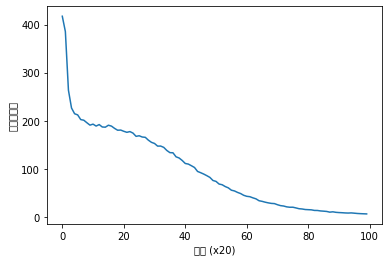

In [16]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

정리해보자면 다음과 같은 순서대로 작업이 이루어진다.

1. 미니배치를 '순차적'으로 만들어

2. 모델의 순전파와 역전파를 호출하고

3. 옵티마이저로 가중치를 갱신하고

4. perplexity를 구한다.

## 5.6 이번 장에서 배운 내용

    * RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다.
    
    * RNN의 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, 보통의 오차역전파법으로 학습할 수 있다.(=BPTT)
    
    * 긴 시계열 데이터를 학습할 때는 데이터를 적당한 길이씩 모으고(이를 '블록'이라 한다.), 블록 단위로 BPTT에 의한 학습을 수행한다(=Truncated BPTT).
    
    * Truncated BPTT에서는 역전파의 연결만 끊는다.
    
    * Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적'으로 입력해야 한다.
    
    * 언어 모델은 단어 시퀸스를 확률로 해석한다.
    
    * RNN 계층을 이용한 조건부 언어 모델은(이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다.

# 6. 게이트가 추가된 RNN

앞 장에서 본 RNN은 순환 경로를 포함해 과거의 정보를 기억할 수 있다. 그러나 단점이 있는데 장기 기억을 못한다는 것이다.

그래서 이번 장에선 '게이트'라는 구조가 더해져 기본RNN의 단점을 극복한 LSTM과 GRU에 대해 알아보자.


### 6.1 RNN의 문제점

기본 RNN은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나서 장기 기억이 힘들다.



### 6.1.2 기울기 소실 또는 기울기 폭발

다음과 같은 예시를 보자.

<img src="deep_learning_2_images/fig 6-3.png" width="70%" height="30%">

'?'에 들어갈 정답은 'Tom'이다. 이 문제에 올바른 대답을 하기 위해선 'Tom이 방에서 Tv를 보고 있음'과 '그 방에 Mary가 들어옴'이란 정보를 기억해둬야 한다. 다시 말해 이런 정보를 RNN 계층의 은닉 상태에 인코딩해 보관해야 한다.

RNNLM관점에서 봐보자.

<img src="deep_learning_2_images/fig 6-4.png" width="60%" height="30%">

RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있는 것이다. 

이때 기울기는 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다. 

하지만 만약 이 기울기가 중간에 사그라들면 가중치 매개변수는 전혀 갱신되지 않게 된다. 즉, 장기 의존 관계를 학습할 수 없게 된다.

이런 경우 단순한 RNN 계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 혹은 커질 수 있으며, 대부분 둘 중 하나이다.


### 6.1.3 기울기 소실과 기울기 폭발의 원인

RNN 계층에서 기울기 소실 or 폭발이 일어나는 원인을 알아보자.

다음은 $tanh(x)$와 $tanh(x)$의 미분 그래프이다.

<img src="deep_learning_2_images/fig 6-6.png" width="50%" height="30%">

미분 값은 1이하이고 $x$가 0으로 멀어질수록 작아진다. 다시 말해서 역전파에서는 기울기가 $tanh$노드를 지날 때마다 값은 계속 작아진다.

다음은 MatMul노드이다.

<img src="deep_learning_2_images/fig 6-7.png" width="60%" height="30%">

전개를 단순화하기 위해 tanh노드를 무시하기로 하자. 그럼 RNN 계층의 역전파 시 기울기는 위와 같은 그림으로 나타난다.

Matmul노드에서 역전파는 $\textbf{dhW}_\textbf{h}^T$라는 행렬 곱으로 기울기를 계산한다.

그리고 같은 계산을 시계열 데이터의 시간 크기만큼 반복한다. 여기에서 주목해야 할 점은 매번 똑같은 가중치인 $\textbf{W}_\textbf{h}$가 사용된다는 점이다.

그러면 역전파 시 기울기는 Matmul 노드를 지날 때 어떻게 변할까?

코드를 통해 알아보자



In [18]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수 
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list_1 = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)이ㅅ
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

In [19]:
norm_list

[2.4684068094579303,
 3.3357049741610365,
 4.783279375373182,
 6.279587332087612,
 8.080776465019053,
 10.251163032292936,
 12.936063506609896,
 16.276861327786712,
 20.45482961834598,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.8244073070191,
 63.79612654485427,
 80.07737014308985,
 100.5129892205125,
 126.16331847536823,
 158.35920648258823,
 198.7710796761195,
 249.495615421267]

Wh의 초깃값을 np.random.randn(H,H) * .5로 하면 급격하게 감소한다. 즉, 기울기 소실이 발생한다.

Wh이 어떻게 변하는지 보기 위해선 행렬의 '특잇값'을 봐야한다.

이 특잇값의 값이 1보다 큰지 여부를 보면 기울기 크기가 어떻게 변할지 예측할 수 있다.

### 6.1.4 기울기 폭발 대책

기울기 폭발 해결책 먼저 알아보자.

먼저 전통적인 기법을 알아보자. 바로 __기울기 클리핑(gradient clipping)__이다. 의사코드는 다음과 같다.

$$ if\;\lVert \hat{\textbf{g}} \rVert \ge threshold: \\ \hat{\textbf{g}} = {threshold \over \lVert \hat{\textbf{g}} \rVert}\hat{\textbf{g}}$$

여기에서는 신경망에서 사용되는 모든 매개변수에 대한 기울기를 하나로 처리한다고 가정하고, 이를 기호 $\lVert \hat{\textbf{g}} \rVert $으로 표기했다.

이제 기울기 클리핑을 구현해보자.

In [20]:
import numpy as np

dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)    
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 기울기 소실과 LSTM

기울기 소실도 큰 문제이다. 이번 장의 핵심 주제인 '게이트'가 추가된 RNN인 LSTM으로 기울기 소실을 해결해보자!

### 6.2.1 LSTM의 인터페이스

LSTM의 계층을 살펴보기 앞서 계산 그래프를 단순화하는 도법을 하나 도입하자.

<img src="deep_learning_2_images/fig 6-10.png" width="80%" height="30%">

위와 같이 변경된 계산 그래프로 RNN와 LSTM을 비교해보자.

<img src="deep_learning_2_images/fig 6-11.png" width="80%" height="30%">

보다시피 LSTM에는 __c__라는 경로가 있다는 차이가 있다. 이 __c__를 __기억 셀(memory cell)__이라고 하며, LSTM 전용의 기억 메커니즘이다.

기억 셀의 특징은 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고받는다는 것이다. 즉, LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력되지 않는다.


### 6.2.2 LSTM 계층 조립하기

이번 설명은 [understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)을 참고했다.

<img src="deep_learning_2_images/fig 6-12.png" width="50%" height="30%">

LSTM 계층 안에서 이루어지는 계산은 위와 같다.

'게이트'라는 기능에 대해 알아보자. 이름에서 알 수 있듯이 게이트는 데이터의 흐름을 제어한다.

<img src="deep_learning_2_images/fig 6-14.png" width="50%" height="30%">




### 6.2.3 output 게이트

바로 앞에서 은닉 상태 $\textbf{h}_t$는 기억 셀 $\textbf{c}_t$에 단순히 $tanh$함수를 적용했을 뿐이라고 설명했다.

이번 절에서는 $tanh(\textbf{c}_t)$에 게이트를 적용하는 걸 생각해보자.

즉, $tanh(\textbf{c}_t)$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정한다.

이 게이트는 다음 은닉 상태 $\textbf{h}_t$의 출력을 담당하는 게이트이므로 __output 게이트__라고 한다.

output 게이트의 열림 상태는 입력 $\textbf{x}_t$와 이전 상태 $\textbf{h}_{t-1}$로부터 구한다.
 
output 게이트는 다음과 같이 쓸 수 있다.

$$\textbf{o}=\sigma(\textbf{x}_t\textbf{W}_\textbf{x}^\textbf{(o)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(o)} + \textbf{b}^\textbf{(o)})$$  

아래의 계산 그래프를 참고하자.

<img src="deep_learning_2_images/fig 6-15.png" width="50%" height="30%">

그리고 $\textbf{h}_t$는 $\textbf{o}$와 $tanh(\textbf{c}_t)$의 곱으로 계산된다. 여기서 말하는 곱이란 원소별 곱이며, 이것을 __아다마르 곱(Hadamar product)__라고 한다. 

기호로는 $\odot$이고 다음과 같은 계산을 수행한다. 

$$\textbf{h}_t = \textbf{o}\odot tanh(\textbf{c}_t)$$

### 6.2.4 forget 게이트

이름에서 알 수 있듯이 불필요한 데이터를 잊는 작업을 하는 게이트다.

계산 그래프로 나타내면 다음과 같다.

<img src="deep_learning_2_images/fig 6-16.png" width="50%" height="30%">

forget 게이트에선 다음 식의 계산이 수행된다.

$$\textbf{f}=\sigma(\textbf{x}_t\textbf{W}_\textbf{x}^\textbf{(f)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(f)} + \textbf{b}^\textbf{(f)})$$


그리고 최종적으로 $\textbf{f}$와 이전 기억 셀인 $\textbf{c}_{t-1}$과의 원소별 곱을 통해 $\textbf{c}_{t}$를 출력한다.

$$\textbf{c}_t = \textbf{f}\odot tanh(\textbf{c}_{t-1})$$

### 6.2.5 새로운  기억 셀

fortget게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었다.

그래서 새로 기억해야 할 정보를 기억 셀에 추가해야 된다. 아래 그림과 같이 $tanh$노드를 추가한다.

<img src="deep_learning_2_images/fig 6-17.png" width="50%" height="30%">

그림에서 보듯 $tanh$노드가 계산한 결과가 이전 시각의 기억 셀 $\textbf{c}_{t-1}$에 더해진다. 

기억 셀에 새로운 '정보'가 추가된 것이다. 이 $tanh$ 노드는 '게이트'가 아니며, 새로운 '정보'를 기억 셀에 추가하는 것이 목적입니다.

$tanh$노드에서 수행되는 계산은 다음과 같다.

$$\textbf{g} = tanh(\textbf{x}_t\textbf{W}_x^\textbf{(g)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(g)} + \textbf{b}^\textbf{(g)})$$

여기에서는 기억 셀에 추가하는 새로운 기억을 $\textbf{g}$로 표기했다.

### 6.2.6 input 게이트

마지막으로 $\textbf{g}$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단하는 __input 게이트__를 추가하자.

이는 새 정보를 무비판적으로 수용하는 게 아니라, 적절히 취사선택하는 것이 이 게이트의 역할이다.

다른 관점으로 보자면, input 게이트에 의해 가중된 정보가 새로 추가되는 것이다.

수행되는 계산은 다음과 같다.

$$\textbf{i} = tanh(\textbf{x}_t\textbf{W}_x^\textbf{(i)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(i)} + \textbf{b}^\textbf{(i)})$$

그리고 $\textbf{i}$와 $\textbf{g}$의 원소별 곱 결과를 기억 셀에 추가한다.

다음은 LSTM 안에서 이뤄지는 과정이다.

<img src="deep_learning_2_images/fig 6-18.png" width="50%" height="30%">

### 6.2.7 LSTM의 기울기 흐름

LSTM에서 어떤 원리로 기울기 소실을 없애주는 걸까? 기억 셀$\textbf{c}$의 역전파에 주목해보자.

<img src="deep_learning_2_images/fig 6-19.png" width="80%" height="50%">

보면 기억 셀의 역전파에서는 '+'와 '$\times$' 노드만을 지나게 된다. 그래서 '$\times$' 노드에서 기울기 변화가 일어난다.

그런데 앞에서 본 RNN의 역전파에서는 똑같은 가중치 행렬로 행렬 곱을 반복했다. 그래서 기울기 소실이 일어났다.

하지만 LSTM의 역전파에서는 행렬 곱이 아닌 원소별 곱이 이뤄지고, 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산한다. 그래서 기울기 소실이 일어나지 않는 것이다.

$\times$노드 계산은 forget 게이트가 제어한다. 그래서 forget 게이트의 값에 의해 흘러가는 기울기의 값이 결정된다. 따라서 기억 셀의 기울기가 소실 없이 전파되리라 기대할 수 있다.

## 6.3 LSTM 구현

우선 최초의 한 단계만 처리하는 LSTM 클래스를 구현한 다음, 이어서 T개의 단계를 한꺼번에 처리하는 Time LSTM 클래스를 구현하겠다.

다음은 LSTM에서 수행하는 계산을 정리한 수식들이다.

$$\begin{matrix}
\textbf{f} &=& \sigma(\textbf{x}_t\textbf{W}_\textbf{x}^\textbf{(f)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(f)} + \textbf{b}^\textbf{(f)}) \\ 
\textbf{g} &=& tanh(\textbf{x}_t\textbf{W}_x^\textbf{(g)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(g)} + \textbf{b}^\textbf{(g)}) \\ 
\textbf{i} &=& tanh(\textbf{x}_t\textbf{W}_x^\textbf{(i)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(i)} + \textbf{b}^\textbf{(i)}) \\ 
\textbf{o} &=& \sigma(\textbf{x}_t\textbf{W}_\textbf{x}^\textbf{(o)} + \textbf{h}_{t-1}\textbf{W}_\textbf{h}^\textbf{(o)} + \textbf{b}^\textbf{(o)})
\end{matrix}$$

$$ \textbf{c}_t = \textbf{f} \odot \textbf{c}_{t-1} + \textbf{g} \odot \textbf{i} $$

$$\textbf{h}_t = \textbf{o}\odot tanh(\textbf{c}_t)$$

여기서 주목할 부분은 네 수식에 포함된 아핀 변환이다. 이를 행렬로 묶어 하나의 식으로 정리할 수 있다.

아래의 그림을 보자.

<img src="deep_learning_2_images/fig 6-20.png" width="60%" height="30%">

위와 같은 과정을 거쳤을 때 계산 그래프를 보자.

<img src="deep_learning_2_images/fig 6-21.png" width="60%" height="30%">

위를 참고하여 LSTM 클래스를 구현해보자.

In [23]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        # 초기화
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        # 순전파때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = 0 * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.3.1 Time LSTM 구현

Time LSTM은 T개분의 시계열 데이터를 한꺼번에 처리하는 계층이다. 다음 그림과 같이 구성되어 있다.

<img src="deep_learning_2_images/fig 6-24.png" width="60%" height="30%">

In [24]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

여기서 구현하는 언어 모델은 앞 장에서 구현한 언어 모델과 거의 같다. 앞 장에서는 Time RNN 계층이 차지하던 부분이 Time LSTM 계층으로 바뀌었는데 그게 유일한 차이이다.

<img src="deep_learning_2_images/fig 6-26.png" width="60%" height="30%">

오른쪽 신경망을 Rnnlm이라는 클래스로 구현할 것이다. Rnnlm 클래스는 앞 장에서 설명한 SimpleRnnlm 클래스와 거의 같고, 새로운 method를 몇 개 더 제공한다.


In [25]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

이제 이 신경망을 사용해 PTB 데이터셋을 학습해보자.

Done
| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 19[s] | 퍼플렉서티 2965.97
| 에폭 1 |  반복 41 / 1327 | 시간 35[s] | 퍼플렉서티 1238.42
| 에폭 1 |  반복 61 / 1327 | 시간 51[s] | 퍼플렉서티 970.91
| 에폭 1 |  반복 81 / 1327 | 시간 67[s] | 퍼플렉서티 816.29
| 에폭 1 |  반복 101 / 1327 | 시간 82[s] | 퍼플렉서티 667.55
| 에폭 1 |  반복 121 / 1327 | 시간 98[s] | 퍼플렉서티 645.83
| 에폭 1 |  반복 141 / 1327 | 시간 113[s] | 퍼플렉서티 598.52
| 에폭 1 |  반복 161 / 1327 | 시간 129[s] | 퍼플렉서티 574.64
| 에폭 1 |  반복 181 / 1327 | 시간 144[s] | 퍼플렉서티 591.08
| 에폭 1 |  반복 201 / 1327 | 시간 160[s] | 퍼플렉서티 515.65
| 에폭 1 |  반복 221 / 1327 | 시간 175[s] | 퍼플렉서티 495.28
| 에폭 1 |  반복 241 / 1327 | 시간 191[s] | 퍼플렉서티 452.63
| 에폭 1 |  반복 261 / 1327 | 시간 210[s] | 퍼플렉서티 472.14
| 에폭 1 |  반복 281 / 1327 | 시간 227[s] | 퍼플렉서티 464.27
| 에폭 1 |  반복 301 / 1327 | 시간 244[s] | 퍼플렉서티 397.72
| 에폭 1 |  반복 321 / 1327 | 시간 259[s] | 퍼플렉서티 351.02
| 에폭 1 |  반복 341 / 1327 | 시간 274[s] | 퍼플렉서티 408.25
| 에폭 1 |  반복 361 / 1327 | 시간 289[s] | 퍼플렉서티 418.44
| 에폭 1 |  반복 381 / 1327 | 시간 304[s] |

| 에폭 3 |  반복 481 / 1327 | 시간 2673[s] | 퍼플렉서티 118.40
| 에폭 3 |  반복 501 / 1327 | 시간 2688[s] | 퍼플렉서티 128.83
| 에폭 3 |  반복 521 / 1327 | 시간 2703[s] | 퍼플렉서티 137.51
| 에폭 3 |  반복 541 / 1327 | 시간 2718[s] | 퍼플렉서티 136.25
| 에폭 3 |  반복 561 / 1327 | 시간 2734[s] | 퍼플렉서티 117.98
| 에폭 3 |  반복 581 / 1327 | 시간 2749[s] | 퍼플렉서티 105.36
| 에폭 3 |  반복 601 / 1327 | 시간 2764[s] | 퍼플렉서티 148.43
| 에폭 3 |  반복 621 / 1327 | 시간 2779[s] | 퍼플렉서티 142.43
| 에폭 3 |  반복 641 / 1327 | 시간 2795[s] | 퍼플렉서티 127.47
| 에폭 3 |  반복 661 / 1327 | 시간 2810[s] | 퍼플렉서티 121.27
| 에폭 3 |  반복 681 / 1327 | 시간 2825[s] | 퍼플렉서티 101.23
| 에폭 3 |  반복 701 / 1327 | 시간 2840[s] | 퍼플렉서티 118.34
| 에폭 3 |  반복 721 / 1327 | 시간 2856[s] | 퍼플렉서티 125.37
| 에폭 3 |  반복 741 / 1327 | 시간 2871[s] | 퍼플렉서티 107.23
| 에폭 3 |  반복 761 / 1327 | 시간 2887[s] | 퍼플렉서티 102.09
| 에폭 3 |  반복 781 / 1327 | 시간 2902[s] | 퍼플렉서티 104.52
| 에폭 3 |  반복 801 / 1327 | 시간 2917[s] | 퍼플렉서티 115.75
| 에폭 3 |  반복 821 / 1327 | 시간 2932[s] | 퍼플렉서티 117.28
| 에폭 3 |  반복 841 / 1327 | 시간 2948[s] | 퍼플렉서티 113.76
| 에폭 3 |  반복

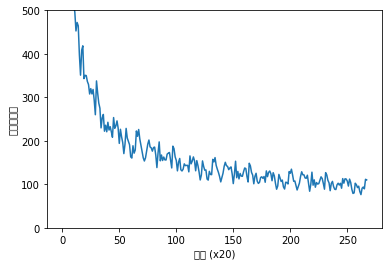

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.60764776603213


In [27]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

## 6.5 RNNLM 추가 개선

RNNLM의 개선 포인트 3가지를 알아보자.

## 6.5.1 LSTM 계층 다층화

RNNLM으로 정확하나 모델을 만들고자 한다면 많은 경우 LSTM 계층을 깊게 쌓아 효과를 볼 수 있다.

<img src="deep_learning_2_images/fig 6-29.png" width="60%" height="30%">

그럼 몇 층이나 쌓아야 할까? 그건 하이퍼파라미터에 관한 문제이다. 문제에 따라 다르다.

참고로 PTB 데이터셋의 언어 모델에서는 LSTM의 층 수는 2~4 정도일 때 좋은 결과를 얻는 것 같습니다.     

### 6.5.2 드롭아웃에 의한 과적합 억제

LSTM 계층을 다층화하면 과적합의 위험이 있다. 그래서 과적합을 억제하는 방법들을 알아보자.

첫 번째로 드랍아웃 계층을 어디에 위치시켜야 할지 생각해야 한다.

아래와 같이 위치시키는 걸 생각해보자.

<img src="deep_learning_2_images/fig 6-32.png" width="60%" height="30%">

이는 좋은 방법이 아니다. 왜냐하면 시계열 방향으로 드롭아웃을 넣어버리면 시간이 흐름에 따라 정보가 사라질 수 있다. 

즉, 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다. 그래서 노이즈 축적을 고려하면, 시간축 방향으로의 드롭아웃은 안하는 것이 좋다.

깊이 방향으로 적용하는 것이 적절하다.

<img src="deep_learning_2_images/fig 6-33.png" width="50%" height="30%">

지금까지 이야기한 것처럼, '일반적인 드롭아웃'은 시간 방향에는 적합하지 않다. 그러나 최근 연구에서는 RNN의 시간 방향 정규화를 목표로 하는 방법이 다양하게 제안되고 있다. 예로 __Variational Dropout__이 있다.

Variational Dropout은 깊이 방향은 물론 시간 방향에도 이용할 수 있어서 언어 모델의 정확도를 한층 더 향상시킬 수 있다.

구조는 이렇다. 같은 계층에 속한 드롭아웃들은 같은 마스크를 공유한다.

'마스크'란 데이터의 '통과/차단'을 결정하는 이진형태의 무작위 패턴을 말한다.

<img src="deep_learning_2_images/fig 6-34.png" width="50%" height="40%">

위에서 보듯 계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 '고정'된다. 그 결과 정보를 잏게 되는 방법도 고정되므로, 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있다.



### 6.5.3 가중치 공유

언어 모델을 개선하는 아주 간단한 트릭 중 __가중치 공유(Weight tying)__이 있다.

다음 사진은 Embedding 계층과 Affine 계층의 가중치를 공유하는 경우이다.

<img src="deep_learning_2_images/fig 6-35.png" width="50%" height="30%">

가중치 공유가 효과가 있는 이유는 다음과 같다.

직관적으로 가중치를 공유함으로써 학습해야할 매개변수 수를 줄일 수 있고, 그 결과 학습하기가 더 쉬워지기 때문이다. 

자세한 내용은 다음 논문을 읽어보자 [weight tying](https://arxiv.org/abs/1611.01462)

## 6.5.34 개선된 RNNLM 구현


앞에서 알아본 개선점 3개를 적용하여 BetterRnnlm 클래스를 구현하자.

    * LSTM 계층의 다층화
    
    * 드롭아웃 사용 (깊이 방향)
    
    * 가중치 공유 (Emdedding 계층과 Affine 계층)

<img src="deep_learning_2_images/fig 6-36.png" width="30%" height="30%">

In [42]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

BetterRnnlm 클래스를 이용해 학습을 해보자.

In [ ]:
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

### 6.5.5 첨단 연구

현재 perplexity를 줄이는 연구가 계속 되고 있다. 몇 가지를 알아보자.

<img src="deep_learning_2_images/fig 6-37.png" width="60%" height="30%">


## 6.6 이번 장에서 배운 내용

    * 단순한 RNN의 학습에서는 기울기 소실과 기울기 폭발이 문제가 된다.
    
    * 기울기 폭발에는 기울기 클리핑, 기울긱 소실에는 게이트가 추가된 RNN(LSTM과 GRU 등이) 효과적이다.
    
    * LSTM에는 input 게이트, forget 게이트, output 게이트 등 3개의 게이트가 있다.
    
    * 게이트에는 전용 가중치가 있으며, 시그모이드 함수를 사용하여 0.0~1.0 사이의 실수를 출력한다.
    
    * 언어 모델 개선에는 LSTM 계층 다층화, 드롭아웃, 가중치 공유 등의 기법이 효과적이다.
    
    * RNN의 정규화는중요한 주제이며, 드롭아웃 기반의 다양한 기법이 제안되고 있다.

# 7 RNN을 사용한 문장 생성

이번 장에서는 언어 모델을 사용해 '문장 생성'을 수행할 것이다. 구체적으로는 우선 말뭉치를 사용해 학습한 언어 모델을 이용하여 새로운 문장을 만들어낸다.

그런 다음 개선된 언어 모델을 이용하여 더 자연스러운 문장을 생성하자.

더 나아가 seq2seq라는 새로운 구조의 신경망도 다룰 것이다. seq2seq란 한 시계열 데이터를 다른 시계열 데이터롤 변환하는 걸 말한다.

이번 장에서는 RNN 두 개를 연결하는 아주 간단한 방법으로 seq2seq를 구현해볼 것이다.

# 7.1 언어 모델을 사용한 문장 생성

이번 절에서는 언어 모델로 문장 생성을 해보자.

### 7.1.1 RNN을 사용한 문장 생성의 순서

언어 모델은 지금까지 주어진 단어들에서 다음에 출현하는 단어의 확률분포를 출력한다. 이 결과를 기초로 다음 단어를 새로 생성하려면 어떻게 해야 할까?

첫 번째로, 확률이 가장 높은 단어를 선택하는 방법이다. 이런 방법을 결정적인 방법이라 부른다.

마지막으로 '확률적'으로 선택하는 방법도 있다. 각 후보 단어의 확률에 맞게 선택하는 것으로, 확률이 높은 단어는 선택되기 쉽고, 낮은 단어는 선택되기 어렵다.

이 방식에서는 선택되는 단어가 매번 다를 수 있다. 따라서 다양한 문장을 생성할 수 있다.

첫 번째 방법도 헷갈리지 말아야 하는게, 첫 번째 방법은 확률이 가장 높은 단어를 '선택'하는 것이고 두 번째 방법은 확률을 근거로 '랜덤뽑기'하는 것이다.

입력 단어로 다음 단어를 생성하고 생성된 단어로 다음 단어를 생성한다. 이런 반복적인 구조를 통해 문장을 생성하는 것이다.

<img src="deep_learning_2_images/fig 7-4.png" width="50%" height="30%">

### 7.1.2 문장 생성 구현

문장을 생성하는 코드를 구현해보자. 앞 장에서 구현한 Rnnlm 클래스를 상속해 RnnlmGen 클래스를 만들고 이 클래스에 문장 생성 method를 추가하자.

In [43]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        
        '''
        start_id : 최초로 주는 단어의 ID
        sample_size : 샘플링하는 단어의 수
        skip_ids : 샘플링되지 않는 단어의 ID를 모아놓은 리스트
        '''
        
        x = start_id   
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

먼저 아무런 학습도 없이 문장을 생성해보자(즉, 가중치 매개변수는 무작위 초깃값인 상태).

In [38]:
import sys
sys.path.append('..')
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

# model.load_params('ch06/Rnnlm.pkl')의 주석처리에 따라 문장의 질이 달라진다.
model = RnnlmGen()
model.load_params('ch06/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you expect half of a policy that can be all the postal programs are offset by its passing involved and a computer system of the eye.
 an economy may be is expected to lose them with american express ltd. morgan stanley & co. by a computer co. unit.
 dual home products between both drug firms especially structure have intended hurting the company could pay in what change customers a month for occurred usually answer.
 he think bowed to defend economic cooperation the economy will be of the mega-issues that sea barriers have.
 all of its assets


### 7.1.3 더 좋은 문장으로

앞 장에서 만든 'BetterRnnlm'을 이용해서 더 좋은 문장을 만들어보자. 앞의 예와 같이 첫 문자로 'you'를 입력해보자.

In [44]:
import sys
sys.path.append('..')
from common.np import *
from ch07.rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('ch06/BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you issue from some succeeded.
 but it 's very difficult to see the word in our editorial right now to resolve and 'm ok says mr. eidsmo.
 one of those many money managers believe they should love things off to side.
 the massachusetts news board would pay over less than pro bono to its new rent and cigarette documents.
 a federal judge in new york upheld an investigation by china 's top management bureau.
 two months ago asarco voted to extend usage of about five million the customers.
 these are the two ministers roll
--------------------------------------------------
the meaning of life is lower but according to the picket drives begun by the morgan stanley pact which came as they acquired used from operations.
 in august.
 the period which tracks from the industrial sector of india was a disappointing slump in his regional city.
 and coal are the main century to cost of u.s. instruments.
 guardian of its roots in the u.s. and europe with keeping their cars this year has been pet.
 

## 7.2 seq2seq

세상엔 다양한 시계열 데이터가 많다. 그래서 입출력이 모두 시계열인 경우도 있다.

그래서 이번에는 시계열 데이터를 다른 시계열 데이터로 변환하는 모델을 생각해보자.

이를 위한 기법으로, 여기에서는 2개의 RNN을 이용하는 __seq2seq__라는 방법을 알아보자.

### 7.2.1 seq2seq의 원리

seq2seq를 Encoder-Decoder 모델이라고 한다. 문자 그대로 Encoder와 Decoder를 이어주는 모델이다.

다음과 같은 경우를 보자.


<img src="deep_learning_2_images/fig 7-5.png" width="40%" height="30%">

'나는 고양이로소이다'를 받아 encoder를 통해 encoding한 값을 decoder를 통해 decodingd을 해서 'I am a cat'으로 출력한다.

먼저 Encoder를 알아보자.

<img src="deep_learning_2_images/fig 7-6.png" width="70%" height="30%">

Encoder는 RNN을 이용해 시계열 데이터를 __h__라는 은닉 상태 벡터로 변환한다.

이 은닉 상태 __h__에 입력 문장을 번역하는데 필요한 정보가 인코딩된다. 여기에서 중요한 점은 __h__는 고정 길이 벡터라는 점이다.

그래서 인코딩 작업은 결국 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업이다.

<img src="deep_learning_2_images/fig 7-7.png" width="50%" height="30%">

이번에는 Decoder를 알아보자.

<img src="deep_learning_2_images/fig 7-8.png" width="70%" height="30%">

이전에서 문장 생성했을 때 사용한 모델을 그대로 적용한다.

단, 한 가지 다른 점이 LSTM 계층이 벡터 __h__를 입력받는다는 점이다.

참고로 앞 절의 언어 모델에서는 LSTM 계층이 아무것도 받지 않았다. 이런 사소한 차이가 번역을 하게 만든다!!

그럼 seq2seq의 전체 계층 구성을 보자

<img src="deep_learning_2_images/fig 7-9.png" width="80%" height="50%">

### 7.2.2 시계열 데이터 변환용 Toy problem

머신러닝을 평가하고자 만든 간단한 문제를 'toy prblem'이라고 부른다.

toy prblem으로 '덧셈'을 학습시켜보자.

<img src="deep_learning_2_images/fig 7-10.png" width="40%" height="30%">

seq2seq는 덧셈의 예제들로부터, 사용되는 문자의 패턴을 학습한다.

과연 이런 식으로 해서 "덧셈의 규칙을 올바르게 학습할 수 있는가?"가 이번 문제의 중점 사항이다.

지금까지 word2vec이나 언어 모델에서 문장을 '단어' 단위로 분할해왔다.

그러나 이번 문제에서는 단어가 아닌 '문자' 단위로 분할한다.

### 7.2.3 가변 길이 시계열 데이터

덧셈을 문자의 리스트로써 다룰 때 주의해야 할 점은 덧셈 문장이나 그 출력의 문자 수가 문제마다 다르다는 것이다.

그러므로 기존의 고정 길이 데이터가 아니라 가변 길이 데이터를 다룬다는 것이다.

따라서 신경망 학습 시 '미니배치 처리'를 하려면 무언가 추가적인 조작이 필요하다.

가장 단순한 방법으로 __패딩__을 사용하는 것이 있다.

패딩이란 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법이다.

다음과 같이 적용을 한다.

<img src="deep_learning_2_images/fig 7-11.png" width="70%" height="30%">

(위의 사진과 같이 decoder 출력의 경우, 문자 출력의 종료를 알리는 구분자를 정답 레이블로 입력하도록 구현할 수 있다. 그러나 여기에서는 단순화하기 위해 그러지 않도록 한다.)

이렇게 패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시계열 데이터도 처리할 수 있다. 

그런데 원래 존재하지 않던 패딩용 문자까지 seq2seq가 학습할 수 있으므로 SoftmaxWithLoss 계층에서 적절한 조치를 통해 해결해야 하지만 복잡하니 여기에선 그냥 다루기로 한다.



### 7.2.4 덧셈 데이터셋

addition.txt에 있는 50,000개의 데이터를 들여다보자.

정석대로라면 데이터셋을 훈련, 검증, 테스트용으로 나눠서 사용해야 하는데 이야기를 단순화하기 위해 훈련, 테스트로만 나눠서 진행하겠다.

In [45]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seq 구현

두 RNN을 Encoder와 Decoder 클래스로 구현하고 두 클래스를 연결하는 seq2seq 클래스를 구현하는 흐름으로 진행해보겠다.

### 7.3.1 Encoder 클래스

Encoder 클래스는 그림과 같이 문자열을 받아 벡터 __h__로 변환한다.


<img src="deep_learning_2_images/fig 7-13.png" width="20%" height="30%">

Encoder 계층을 다시보자.

<img src="deep_learning_2_images/fig 7-14.png" width="50%" height="30%">

LSTM 계층에서 오른쪽으로 은닉 상태와 셀을 출력하고 위쪽으로 은닉 상태만 출력한다. 그런데 위쪽으로 계층이 없으니 LSTM 계층의 위쪽 출력은 폐기된다.

그리고 마지막 문자를 처리한 후 LSTM 계층의 은닉 상태 __h__를 출력하고 이 값은 Decoder로 전달된다.

Encoder 클래스의 코드를 보자.

In [46]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

여기서 주의해야 할 점이 'stateful'변수인데 지금까지는 긴 시계열 데이터가 하나뿐인 문제를 다뤄와서 Time LSTM 계층의 stateful을 True로 설정하여 은닉 상태를 유지했다.

그러나 이번에는 짧은 시계열 데이터가 여러 개이기 때문에 문제마다 LSTM의 은닉 상태를 다시 초기화해야하기 때문에 False로 설정해야 한다.

### 7.3.2 Decoder 클래스

앞에서 알아봤던 것 처럼 decoder는 encoder에서 출력한 __h__를 받아 목적으로 하는 다른 문자열을 출력한다.

Encoder와 마찬가지로 LSTM 계층을 사용한다. 학습 시 계층 구성은 다음과 같다.

<img src="deep_learning_2_images/fig 7-17.png" width="60%" height="30%">

그런데 7.1절에서는 확률적 선택을 했는데 이 문제는 '덧셈'문제이므로 '결정적'인 답을 요구한다. 그러므로 softmax함수의 확률분포에서 점수가 가장 높은 문자 하나만 고르겠다.

다음은 문자열 생성 시 계층 구성을 보자.

<img src="deep_learning_2_images/fig 7-18.png" width="60%" height="30%">

보시다시피 argmax라는 노드를 통해 최댓값을 가진 원소의 인덱스를 선택해서 반환한다. 다만 이번에는 softmax 계층을 사용하지 않고, Affine 계층이 출력하는 점수가 가장 큰 문자 ID를 선택한다. 

왜냐하면 softmax함수는 단조 증가 함수이기 때문에 적용 전후의 대소 관계가 달라지지 않기 때문이다.

이렇게 decoder에서는 학습 시와 생성 시에 Softmax 계층을 다르게 취급한다. 그러니 SoftmaxWithLoss 계층은 이후에 구현하는 seq2seq 클래스에서 처리하기로 하고, decoder 클래스는 Time Softmax With Loss 계층의 앞까지만 담당하기로 하자.

<img src="deep_learning_2_images/fig 7-19.png" width="40%" height="30%">

Decoder 클래스는 Time Embedding, Time LSTM, Time Affine의 3가지 계층으로 구성된다.

구현해보자.




In [49]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        # 한 번 설정된 이 은닉 상태는 재설정되지 않고, 즉 Encoder의 h를 유지하면서 순전파가 이루어진다.
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

잠시 역전파에 관해서 보충 설명을 하겠다. backward() method는 위쪽의 Softmax With Loss 계층으로 기울기 dscore를 받아 Time Affine 계층, Time LSTM 계층, Time Embedding 계층 순서로 전파시킨다.

이때 Time LSTM 계층의 시간 방향으로의 기울기는 TimeLSTM 클래스의 인스턴스 변수 dh에 저장되어 있다(자세한 내용은 6.3참고).

그래서 이 시간 방향의 기울기 dh를 꺼내서 Decoder 클래스의 backward()의 출력으로 반환한다.

### 7.3.3 Seq2seq 클래스

seq2seq 클래스   

In [48]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 7.3.4 seq2seq 평가

seq2seq의 학습은 다음과 같은 흐름으로 이뤄진다.

1. 학습 데이터에서 미니배치를 선택하고,


2. 미니배치로부터 기울기를 계산하고,


3. 기울기를 사용하여 매개변수를 갱신한다.



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 3[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 5[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 7[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 9[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 11[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 13[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 15[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 17[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 19[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 22[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 24[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 26[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 28[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 30[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 32[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 35[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 37[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000

| 에폭 8 |  반복 21 / 351 | 시간 2[s] | 손실 1.03
| 에폭 8 |  반복 41 / 351 | 시간 4[s] | 손실 1.03
| 에폭 8 |  반복 61 / 351 | 시간 7[s] | 손실 1.04
| 에폭 8 |  반복 81 / 351 | 시간 9[s] | 손실 1.06
| 에폭 8 |  반복 101 / 351 | 시간 11[s] | 손실 1.08
| 에폭 8 |  반복 121 / 351 | 시간 13[s] | 손실 1.07
| 에폭 8 |  반복 141 / 351 | 시간 15[s] | 손실 1.06
| 에폭 8 |  반복 161 / 351 | 시간 18[s] | 손실 1.04
| 에폭 8 |  반복 181 / 351 | 시간 20[s] | 손실 1.02
| 에폭 8 |  반복 201 / 351 | 시간 22[s] | 손실 1.03
| 에폭 8 |  반복 221 / 351 | 시간 24[s] | 손실 1.03
| 에폭 8 |  반복 241 / 351 | 시간 26[s] | 손실 1.02
| 에폭 8 |  반복 261 / 351 | 시간 29[s] | 손실 1.06
| 에폭 8 |  반복 281 / 351 | 시간 31[s] | 손실 1.05
| 에폭 8 |  반복 301 / 351 | 시간 33[s] | 손실 1.04
| 에폭 8 |  반복 321 / 351 | 시간 35[s] | 손실 1.05
| 에폭 8 |  반복 341 / 351 | 시간 37[s] | 손실 1.04
Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 661 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 411 
---
Q 600+257
T 857 
☒ 851 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1410
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93

| 에폭 15 |  반복 21 / 351 | 시간 2[s] | 손실 0.86
| 에폭 15 |  반복 41 / 351 | 시간 4[s] | 손실 0.89
| 에폭 15 |  반복 61 / 351 | 시간 6[s] | 손실 0.91
| 에폭 15 |  반복 81 / 351 | 시간 8[s] | 손실 0.90
| 에폭 15 |  반복 101 / 351 | 시간 11[s] | 손실 0.90
| 에폭 15 |  반복 121 / 351 | 시간 13[s] | 손실 0.89
| 에폭 15 |  반복 141 / 351 | 시간 15[s] | 손실 0.89
| 에폭 15 |  반복 161 / 351 | 시간 17[s] | 손실 0.90
| 에폭 15 |  반복 181 / 351 | 시간 20[s] | 손실 0.89
| 에폭 15 |  반복 201 / 351 | 시간 22[s] | 손실 0.89
| 에폭 15 |  반복 221 / 351 | 시간 24[s] | 손실 0.90
| 에폭 15 |  반복 241 / 351 | 시간 26[s] | 손실 0.89
| 에폭 15 |  반복 261 / 351 | 시간 29[s] | 손실 0.90
| 에폭 15 |  반복 281 / 351 | 시간 31[s] | 손실 0.90
| 에폭 15 |  반복 301 / 351 | 시간 33[s] | 손실 0.88
| 에폭 15 |  반복 321 / 351 | 시간 35[s] | 손실 0.89
| 에폭 15 |  반복 341 / 351 | 시간 38[s] | 손실 0.90
Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1138
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 172 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1441
---
Q 26+838 
T 864 
☒ 

검증 정확도 11.580%
| 에폭 22 |  반복 1 / 351 | 시간 0[s] | 손실 0.79
| 에폭 22 |  반복 21 / 351 | 시간 2[s] | 손실 0.79
| 에폭 22 |  반복 41 / 351 | 시간 4[s] | 손실 0.84
| 에폭 22 |  반복 61 / 351 | 시간 6[s] | 손실 0.79
| 에폭 22 |  반복 81 / 351 | 시간 8[s] | 손실 0.81
| 에폭 22 |  반복 101 / 351 | 시간 10[s] | 손실 0.78
| 에폭 22 |  반복 121 / 351 | 시간 13[s] | 손실 0.79
| 에폭 22 |  반복 141 / 351 | 시간 15[s] | 손실 0.79
| 에폭 22 |  반복 161 / 351 | 시간 17[s] | 손실 0.81
| 에폭 22 |  반복 181 / 351 | 시간 19[s] | 손실 0.84
| 에폭 22 |  반복 201 / 351 | 시간 21[s] | 손실 0.84
| 에폭 22 |  반복 221 / 351 | 시간 23[s] | 손실 0.82
| 에폭 22 |  반복 241 / 351 | 시간 26[s] | 손실 0.82
| 에폭 22 |  반복 261 / 351 | 시간 28[s] | 손실 0.79
| 에폭 22 |  반복 281 / 351 | 시간 30[s] | 손실 0.79
| 에폭 22 |  반복 301 / 351 | 시간 32[s] | 손실 0.78
| 에폭 22 |  반복 321 / 351 | 시간 34[s] | 손실 0.78
| 에폭 22 |  반복 341 / 351 | 시간 37[s] | 손실 0.79
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 432 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒

/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jiho8732/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backen

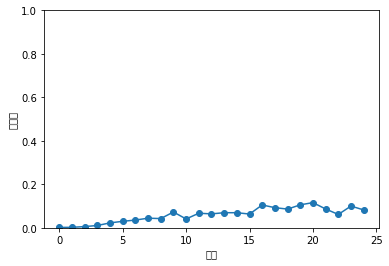

In [53]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


## 7.4 seq2seq 개선

이번에는 앞 절의 seq2seq를 세분화하여 학습 '속도'를 개선하고자 한다. 두 가지 기법을 소개하겠다.

### 7.4.1 입력 데이터 반전(Reverse)

첫 번째로 말 그대로 입력 데이터의 순서를 반전시키는 것이다.

<img src="deep_learning_2_images/fig 7-23.png" width="50%" height="30%">

이 트릭을 사용하면 많은 경우 학습 진행이 빨라져서, 결과적으로 최종 정확도도 좋아진다고 합니다. 

그러면 왜 입력 데이터를 반전시키는 것만으로 학습의 진행이 빨라지고 정확도가 향상되는 걸까? 

정확하진 않지만 직관적으로 기울기 전파가 원활해지기 때문이라고 생각된다.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 2[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 4[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 6[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 8[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 10[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 12[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 14[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 16[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 18[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 20[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 24[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 27[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 30[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 33[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 35[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 37[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 40[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000

| 에폭 8 |  반복 21 / 351 | 시간 2[s] | 손실 1.03
| 에폭 8 |  반복 41 / 351 | 시간 4[s] | 손실 1.03
| 에폭 8 |  반복 61 / 351 | 시간 6[s] | 손실 1.04
| 에폭 8 |  반복 81 / 351 | 시간 8[s] | 손실 1.06
| 에폭 8 |  반복 101 / 351 | 시간 11[s] | 손실 1.08
| 에폭 8 |  반복 121 / 351 | 시간 13[s] | 손실 1.07
| 에폭 8 |  반복 141 / 351 | 시간 15[s] | 손실 1.06
| 에폭 8 |  반복 161 / 351 | 시간 17[s] | 손실 1.04
| 에폭 8 |  반복 181 / 351 | 시간 19[s] | 손실 1.02
| 에폭 8 |  반복 201 / 351 | 시간 21[s] | 손실 1.03
| 에폭 8 |  반복 221 / 351 | 시간 24[s] | 손실 1.03
| 에폭 8 |  반복 241 / 351 | 시간 26[s] | 손실 1.02
| 에폭 8 |  반복 261 / 351 | 시간 28[s] | 손실 1.06
| 에폭 8 |  반복 281 / 351 | 시간 30[s] | 손실 1.05
| 에폭 8 |  반복 301 / 351 | 시간 33[s] | 손실 1.04
| 에폭 8 |  반복 321 / 351 | 시간 36[s] | 손실 1.05
| 에폭 8 |  반복 341 / 351 | 시간 38[s] | 손실 1.04
Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 661 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 411 
---
Q 600+257
T 857 
☒ 851 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1410
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93

검증 정확도 6.940%
| 에폭 15 |  반복 1 / 351 | 시간 0[s] | 손실 0.83
| 에폭 15 |  반복 21 / 351 | 시간 3[s] | 손실 0.86
| 에폭 15 |  반복 41 / 351 | 시간 5[s] | 손실 0.89
| 에폭 15 |  반복 61 / 351 | 시간 9[s] | 손실 0.91
| 에폭 15 |  반복 81 / 351 | 시간 11[s] | 손실 0.90
| 에폭 15 |  반복 101 / 351 | 시간 14[s] | 손실 0.90
| 에폭 15 |  반복 121 / 351 | 시간 17[s] | 손실 0.89
| 에폭 15 |  반복 141 / 351 | 시간 20[s] | 손실 0.89
| 에폭 15 |  반복 161 / 351 | 시간 23[s] | 손실 0.90
| 에폭 15 |  반복 181 / 351 | 시간 25[s] | 손실 0.89
| 에폭 15 |  반복 201 / 351 | 시간 28[s] | 손실 0.89
| 에폭 15 |  반복 221 / 351 | 시간 32[s] | 손실 0.90
| 에폭 15 |  반복 241 / 351 | 시간 36[s] | 손실 0.89
| 에폭 15 |  반복 261 / 351 | 시간 39[s] | 손실 0.90
| 에폭 15 |  반복 281 / 351 | 시간 42[s] | 손실 0.90
| 에폭 15 |  반복 301 / 351 | 시간 45[s] | 손실 0.88
| 에폭 15 |  반복 321 / 351 | 시간 47[s] | 손실 0.89
| 에폭 15 |  반복 341 / 351 | 시간 50[s] | 손실 0.90
Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1138
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 172 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒

검증 정확도 11.580%
| 에폭 22 |  반복 1 / 351 | 시간 0[s] | 손실 0.79
| 에폭 22 |  반복 21 / 351 | 시간 2[s] | 손실 0.79
| 에폭 22 |  반복 41 / 351 | 시간 4[s] | 손실 0.84
| 에폭 22 |  반복 61 / 351 | 시간 6[s] | 손실 0.79
| 에폭 22 |  반복 81 / 351 | 시간 8[s] | 손실 0.81
| 에폭 22 |  반복 101 / 351 | 시간 10[s] | 손실 0.78
| 에폭 22 |  반복 121 / 351 | 시간 12[s] | 손실 0.79
| 에폭 22 |  반복 141 / 351 | 시간 14[s] | 손실 0.79
| 에폭 22 |  반복 161 / 351 | 시간 16[s] | 손실 0.81
| 에폭 22 |  반복 181 / 351 | 시간 18[s] | 손실 0.84
| 에폭 22 |  반복 201 / 351 | 시간 21[s] | 손실 0.84
| 에폭 22 |  반복 221 / 351 | 시간 23[s] | 손실 0.82
| 에폭 22 |  반복 241 / 351 | 시간 25[s] | 손실 0.82
| 에폭 22 |  반복 261 / 351 | 시간 27[s] | 손실 0.79
| 에폭 22 |  반복 281 / 351 | 시간 29[s] | 손실 0.79
| 에폭 22 |  반복 301 / 351 | 시간 31[s] | 손실 0.78
| 에폭 22 |  반복 321 / 351 | 시간 34[s] | 손실 0.78
| 에폭 22 |  반복 341 / 351 | 시간 36[s] | 손실 0.79
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 432 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒

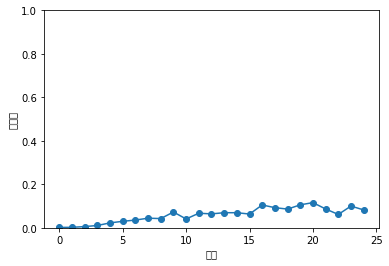

In [55]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


### 7.4.2 엿보기(Peeky)

두 번째 개선을 알아보자.

중요한 정보가 담긴 Encoder의 출력 __h__를 decoder의 다른 계층에게도 전해주는 것이다. 

<img src="deep_learning_2_images/fig 7-26.png" width="50%" height="30%">

위에서와 같이 모든 시각의 Affine 계층과 LSTM 계층에 Encoder의 출력 __h__를 전해준다.

기존에는 하나의 LSTM만이 소유하던 중요 정보 __h__를 여러 계층이 공유함을 알 수 있다.

h를 입력 받는 계층이 2개(LSTM, Affine)가 되었다. 이는 실제로 두 벡터가 연결된 것을 의미한다. 

따라서 다음 그림은 두 벡터를 연결시키는 concat노드를 이용해 그린 계산 그래프이다.

<img src="deep_learning_2_images/fig 7-27.png" width="60%" height="30%">

peeky decoder 클래스를 구현해보자.

In [56]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

다음은 peekyseq2seq 클래스이다. 앞 절의 seq2seq 클래스와 거의 같고 유일한 차이는 decoder 계층이다.

앞 절의 seq2seq 클래스가 decoder 클래스를 사용한 반면 이번에는 peekydecoder를 사용한다.

다음과 같다.

In [57]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

보다시피 peeky와 reverse를 적용시킨 결과는 엄청나게 향상된걸 알 수 있다.

<img src="deep_learning_2_images/fig 7-28.png" width="60%" height="30%">

그러나 주의해야 할 점이 peeky를 사용하게 되면 매개변수의 증가로 계산량이 커진다는 것이 있다.

## 7.5 seq2seq를 이용하는 애플리케이션

입출력이 시계열 데이터인 경우 사용할 수 있는 예시들 다음과 같은 경우들이 있다.

    * 기계 번역 : 한 언어의 문장을 다른 언어의 문장으로 변환
    
    
    * 자동 요약 : 긴 문장을 짧게 요약한 문장으로 변환
    
    
    * 질의응답 : 질문을 응답으로 변환
    
    
    * 메일 자동 응답 : 받은 메일의 문장을 답변 글로 변환

### 7.5.1 챗봇

<img src="deep_learning_2_images/fig 7-29.png" width="50%" height="30%">


### 7.5.2  알고리즘 학습

<img src="deep_learning_2_images/fig 7-30.png" width="60%" height="30%">

### 7.5.3 이미지 캡셔닝

이미지 캡셔닝은 이미지를 문장으로 변환하는 방법이다. 

<img src="deep_learning_2_images/fig 7-32.png" width="50%" height="30%">

## 7.6 이번 장에서 배운 내용

    * RNN을 이용한 언어 모델은 새로운 문장을 생성할 수 있다.
    
    * 문장을 생성할 때는 하나의 단어(혹은 문자)를 주고 모델의 출력(확률분포)에서 샘플링하는 과정을 반복한다.
    
    * RNN을 2개 조합으로써 시계열 데이터를 다른 시계열 데이터로 변환할 수 있다.
    
    * seq2seq는 encoder가 출발어 입력문을 인코딩하고, 인코딩된 정보를 decoder가 받아 디코딩항 도착어 출력문을 얻는다.
    
    * 입력문을 반전시키는 기법(reverse), 또는 인코딩된 정보를 decoder의 여러 계층에 전달하는 기법(peeky)은 seq2seq의 정확도 항샹에 효과적이다.
    
    * 기계번역, 챗봇, 이미지 캡셔닝 등 seq2seq는 다양한 애플리케이션에 이용할 수 있다.